### Imports

In [41]:
# Imports
import numpy as np # math

from astropy.table import Table # Reading and storing the data tables
from astropy.coordinates import SkyCoord # crossmatching coordinates
from astropy.cosmology import Planck18 as cosmo # cosmology for luminosity distance

import astropy.units as u # units and stuffs

import matplotlib.pyplot as plt # plots

# Loading Data

## eRASS1

Load in and check structure of the eRASS1 main source catalogue. <br>
Available to download from [here (ID 1)](https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/).

In [42]:
eRASS_sources_full = Table.read("../Data/eRASS1_Main.v1.1.fits", format='fits')
print(len(eRASS_sources_full), "Sources")
eRASS_sources_full[0:3]

930203 Sources


IAUNAME,DETUID,SKYTILE,ID_SRC,UID,UID_Hard,ID_CLUSTER,RA,DEC,RA_RAW,DEC_RAW,RA_LOWERR,RA_UPERR,DEC_LOWERR,DEC_UPERR,POS_ERR,RADEC_ERR,LII,BII,ELON,ELAT,MJD,MJD_MIN,MJD_MAX,EXT,EXT_ERR,EXT_LOWERR,EXT_UPERR,EXT_LIKE,DET_LIKE_0,ML_CTS_1,ML_CTS_ERR_1,ML_CTS_LOWERR_1,ML_CTS_UPERR_1,ML_RATE_1,ML_RATE_ERR_1,ML_RATE_LOWERR_1,ML_RATE_UPERR_1,ML_FLUX_1,ML_FLUX_ERR_1,ML_FLUX_LOWERR_1,ML_FLUX_UPERR_1,ML_BKG_1,ML_EXP_1,ML_EEF_1,APE_CTS_1,APE_BKG_1,APE_EXP_1,APE_RADIUS_1,APE_POIS_1,DET_LIKE_P1,ML_CTS_P1,ML_CTS_ERR_P1,ML_CTS_LOWERR_P1,ML_CTS_UPERR_P1,ML_RATE_P1,ML_RATE_ERR_P1,ML_RATE_LOWERR_P1,ML_RATE_UPERR_P1,ML_FLUX_P1,ML_FLUX_ERR_P1,ML_FLUX_LOWERR_P1,ML_FLUX_UPERR_P1,ML_BKG_P1,ML_EXP_P1,ML_EEF_P1,APE_CTS_P1,APE_BKG_P1,APE_EXP_P1,APE_RADIUS_P1,APE_POIS_P1,DET_LIKE_P2,ML_CTS_P2,ML_CTS_ERR_P2,ML_CTS_LOWERR_P2,ML_CTS_UPERR_P2,ML_RATE_P2,ML_RATE_ERR_P2,ML_RATE_LOWERR_P2,ML_RATE_UPERR_P2,ML_FLUX_P2,ML_FLUX_ERR_P2,ML_FLUX_LOWERR_P2,ML_FLUX_UPERR_P2,ML_BKG_P2,ML_EXP_P2,ML_EEF_P2,APE_CTS_P2,APE_BKG_P2,APE_EXP_P2,APE_RADIUS_P2,APE_POIS_P2,DET_LIKE_P3,ML_CTS_P3,ML_CTS_ERR_P3,ML_CTS_LOWERR_P3,ML_CTS_UPERR_P3,ML_RATE_P3,ML_RATE_ERR_P3,ML_RATE_LOWERR_P3,ML_RATE_UPERR_P3,ML_FLUX_P3,ML_FLUX_ERR_P3,ML_FLUX_LOWERR_P3,ML_FLUX_UPERR_P3,ML_BKG_P3,ML_EXP_P3,ML_EEF_P3,APE_CTS_P3,APE_BKG_P3,APE_EXP_P3,APE_RADIUS_P3,APE_POIS_P3,DET_LIKE_P4,ML_CTS_P4,ML_CTS_ERR_P4,ML_CTS_LOWERR_P4,ML_CTS_UPERR_P4,ML_RATE_P4,ML_RATE_ERR_P4,ML_RATE_LOWERR_P4,ML_RATE_UPERR_P4,ML_FLUX_P4,ML_FLUX_ERR_P4,ML_FLUX_LOWERR_P4,ML_FLUX_UPERR_P4,ML_BKG_P4,ML_EXP_P4,ML_EEF_P4,APE_CTS_P4,APE_BKG_P4,APE_EXP_P4,APE_RADIUS_P4,APE_POIS_P4,DET_LIKE_P5,ML_CTS_P5,ML_CTS_ERR_P5,ML_CTS_LOWERR_P5,ML_CTS_UPERR_P5,ML_RATE_P5,ML_RATE_ERR_P5,ML_RATE_LOWERR_P5,ML_RATE_UPERR_P5,ML_FLUX_P5,ML_FLUX_ERR_P5,ML_FLUX_LOWERR_P5,ML_FLUX_UPERR_P5,ML_BKG_P5,ML_EXP_P5,ML_EEF_P5,APE_CTS_P5,APE_BKG_P5,APE_EXP_P5,APE_RADIUS_P5,APE_POIS_P5,DET_LIKE_P6,ML_CTS_P6,ML_CTS_ERR_P6,ML_CTS_LOWERR_P6,ML_CTS_UPERR_P6,ML_RATE_P6,ML_RATE_ERR_P6,ML_RATE_LOWERR_P6,ML_RATE_UPERR_P6,ML_FLUX_P6,ML_FLUX_ERR_P6,ML_FLUX_LOWERR_P6,ML_FLUX_UPERR_P6,ML_BKG_P6,ML_EXP_P6,ML_EEF_P6,APE_CTS_P6,APE_BKG_P6,APE_EXP_P6,APE_RADIUS_P6,APE_POIS_P6,DET_LIKE_P7,ML_CTS_P7,ML_CTS_ERR_P7,ML_CTS_LOWERR_P7,ML_CTS_UPERR_P7,ML_RATE_P7,ML_RATE_ERR_P7,ML_RATE_LOWERR_P7,ML_RATE_UPERR_P7,ML_FLUX_P7,ML_FLUX_ERR_P7,ML_FLUX_LOWERR_P7,ML_FLUX_UPERR_P7,ML_BKG_P7,ML_EXP_P7,ML_EEF_P7,APE_CTS_P7,APE_BKG_P7,APE_EXP_P7,APE_RADIUS_P7,APE_POIS_P7,DET_LIKE_P8,ML_CTS_P8,ML_CTS_ERR_P8,ML_CTS_LOWERR_P8,ML_CTS_UPERR_P8,ML_RATE_P8,ML_RATE_ERR_P8,ML_RATE_LOWERR_P8,ML_RATE_UPERR_P8,ML_FLUX_P8,ML_FLUX_ERR_P8,ML_FLUX_LOWERR_P8,ML_FLUX_UPERR_P8,ML_BKG_P8,ML_EXP_P8,ML_EEF_P8,APE_CTS_P8,APE_BKG_P8,APE_EXP_P8,APE_RADIUS_P8,APE_POIS_P8,DET_LIKE_P9,ML_CTS_P9,ML_CTS_ERR_P9,ML_CTS_LOWERR_P9,ML_CTS_UPERR_P9,ML_RATE_P9,ML_RATE_ERR_P9,ML_RATE_LOWERR_P9,ML_RATE_UPERR_P9,ML_FLUX_P9,ML_FLUX_ERR_P9,ML_FLUX_LOWERR_P9,ML_FLUX_UPERR_P9,ML_BKG_P9,ML_EXP_P9,ML_EEF_P9,APE_CTS_P9,APE_BKG_P9,APE_EXP_P9,APE_RADIUS_P9,APE_POIS_P9,APE_CTS_S,APE_BKG_S,APE_EXP_S,APE_POIS_S,FLAG_SP_SNR,FLAG_SP_BPS,FLAG_SP_SCL,FLAG_SP_LGA,FLAG_SP_GC_CONS,FLAG_NO_RADEC_ERR,FLAG_NO_EXT_ERR,FLAG_NO_CTS_ERR,FLAG_OPT
,,,,,,,deg,deg,deg,deg,arcsec,arcsec,arcsec,arcsec,,,deg,deg,deg,deg,d,d,d,arcsec,arcsec,arcsec,arcsec,,,ct,ct,ct,ct,ct / s,ct / s,ct / s,ct / s,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),1 / arcmin2,s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),1 / arcmin2,s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),1 / arcmin2,s,,,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),1 / arcmin2,s,,ct,ct,s,pix,,,ct,ct,ct,,ct / s,ct / s,ct / s,ct / s,erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),erg / (cm2 s),1 / arcmin2,s,,ct,ct,s,pix,,,ct,c

Select the columns I will require so it is easier to use table.<br>

- IAUNAME
- UID
- RA
- DEC
- RADEC_ERR
- EXT
- ML_FLUX_1


Will also select point source (`EXT == 0`)


In [43]:
eRASS_sources = eRASS_sources_full['IAUNAME', 'UID', 'RA', 'DEC', 'RADEC_ERR', 'EXT', 'ML_FLUX_1']
eRASS_sources = eRASS_sources[eRASS_sources['EXT']== 0]
print(len(eRASS_sources), "Point Sources")
eRASS_sources[0:5]

903521 Point Sources


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1
,,deg,deg,,arcsec,erg / (cm2 s)
bytes23,int64,float64,float64,float32,float32,float32
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693,0.0,1.5508955e-12
1eRASS J005448.9-311230,101212000004,13.70410463883818,-31.208436362171515,1.652596,0.0,6.9885916e-13
1eRASS J012910.8-214156,102111100001,22.295164764919686,-21.698997556091005,0.62720245,0.0,3.4790614e-12
1eRASS J012338.1-231059,102111400001,20.90908484230626,-23.183134713205,1.2023203,0.0,1.1919693e-11
1eRASS J015219.0-183235,102710800003,28.079291921052764,-18.543088853166505,1.3169006,0.0,8.0001153e-13


## GAIA QSOs

Gaia data from [gaia archive](https://gea.esac.esa.int/archive/) using the follow Query:<br>
```SQL
SELECT g.source_id, g.ra, g.dec, g.pm, qs.gaia_crf_source,
qs.host_galaxy_flag, qs.classprob_dsc_combmod_quasar,
qs.classlabel_dsc_joint, qs.vari_best_class_name, qs.redshift_qsoc
FROM gaiadr3.qso_candidates as qs
JOIN gaiadr3.gaia_source as g
USING (solution_id, source_id)
WHERE (qs.gaia_crf_source='true' OR qs.host_galaxy_flag<6
OR qs.classlabel_dsc_joint='quasar' OR qs.vari_best_class_name='AGN')
```
<br>

This query is based on the one listed in [Table 11 of the GAIA DR3 extragalactic paper](https://doi.org/10.1051/0004-6361/202243232)

In [44]:
gaia_qso_sources = Table.read("../Data/GAIA_Quasars_Full.csv")
print(len(gaia_qso_sources), "Sources")
gaia_qso_sources[0:3]

c:\Users\Toby\anaconda3\envs\Personal\lib\site-packages\astropy\io\ascii\fastbasic.py:128: AstropyWarning: OverflowError converting to IntType in column source_id, reverting to String.
  data, comments = self.engine.read(try_int, try_float, try_string)


1942825 Sources


source_id,ra,dec,pm,gaia_crf_source,host_galaxy_flag,classprob_dsc_combmod_quasar,classlabel_dsc_joint,vari_best_class_name,redshift_qsoc
str19,float64,float64,float64,str5,int32,float64,str12,str15,float64
4152040546849964288,269.42343013804424,-11.250076967522755,1.1517469,true,--,1.2516455e-07,unclassified,--,--
5939392802025441152,252.6345739540496,-47.708030634186045,1.6419761,false,3,2.2428847e-07,unclassified,SYST,--
5939534600358282880,250.96523522423945,-47.670558949993385,2.3291168,false,3,0.00018701961,unclassified,--,--


Many of these sources do not have redshift so remove these and also only select required columns

- source_id
- ra
- dec
- redshift_qsoc

In [45]:
gaia_qso_sources = gaia_qso_sources[~np.isnan(gaia_qso_sources['redshift_qsoc']).mask]
gaia_qso_sources = gaia_qso_sources['source_id', 'ra', 'dec', 'redshift_qsoc']
print(len(gaia_qso_sources), "Sources with redshifts")
gaia_qso_sources[0:5]

1729625 Sources with redshifts


source_id,ra,dec,redshift_qsoc
str19,float64,float64,float64
5823582960248697728,230.7076929999774,-67.69752390372247,2.491088
5823596601041876736,230.68012821621508,-67.6218345443544,0.15514289
5823630514109745664,231.10371480375875,-67.28434173231645,0.74870634
5823637111177947520,231.06011701973114,-67.10952092968711,0.09709132
5823659754273471872,230.6431087626876,-67.14305101603547,3.3342328


### Purer GAIA Quasars

Basically same as normal gaia except with `AND` instead of `OR`.
Not sure if this will actually be cleaner, but I thought it was strange than many were labeled as `"unclassified"`


In [46]:
purer_gaia_sources = Table.read("../Data/purer_GAIA_Quasars.csv")
print(len(purer_gaia_sources), "Quasar Sources")
## Don't need to check for redshifts since all have redshifts
# purer_gaia_sources = purer_gaia_sources[~np.isnan(purer_gaia_sources['redshift_qsoc']).mask]
purer_gaia_sources = purer_gaia_sources['source_id', 'ra', 'dec', 'redshift_qsoc']
purer_gaia_sources[0:3]

214104 Quasar Sources


source_id,ra,dec,redshift_qsoc
str19,float64,float64,float64
6653810339087893504,273.6394413022079,-53.20260279604084,1.7522463
6836620846036858880,327.1195114093446,-18.471707923850712,1.5499382
6836649089741920384,327.5054348897559,-18.33581567293887,1.9532677


# Crossmatching

For now, will just use a cut off separation of 3 arcsecs

In [47]:
gaia_coords = SkyCoord(ra=gaia_qso_sources['ra']*u.deg, dec=gaia_qso_sources['dec']*u.deg)
eRASS_coords = SkyCoord(ra=eRASS_sources['RA'], dec=eRASS_sources['DEC']) # eRASS data has units on it coordinates 😀

ids, d2d, d3d = eRASS_coords.match_to_catalog_sky(gaia_coords)

max_separation = u.Quantity(3,"arcsec")
separation_condition = d2d < max_separation

print(np.count_nonzero(separation_condition), "matches within 3 arcsec")

63211 matches within 3 arcsec


Histogram of the distribution of separations.

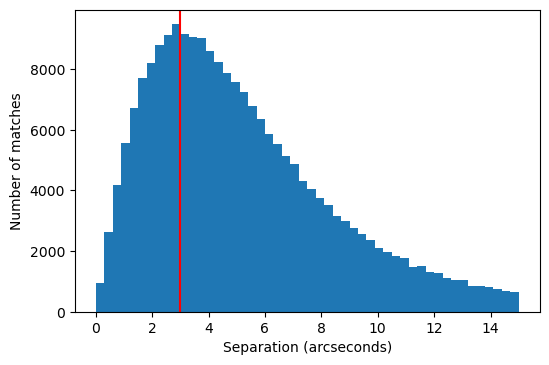

In [48]:
plt.figure(dpi=100)
counts, bins, *_ = plt.hist(d2d.arcsec[d2d < u.Quantity(15, "arcsec")], bins=50)

plt.axvline(max_separation.value, c='r')
plt.ylabel("Number of matches")
plt.xlabel("Separation (arcseconds)")
plt.show()

Create new Table with matched Quasars

In [49]:
matched_quasars = eRASS_sources[separation_condition]
matched_quasars['GAIA_source_id'] = gaia_qso_sources[ids[separation_condition]]['source_id']
matched_quasars['GAIA_redshift'] = gaia_qso_sources[ids[separation_condition]]['redshift_qsoc']

print(len(matched_quasars), "matched x-ray quasars.")
matched_quasars[0:3]


63211 matched x-ray quasars.


IAUNAME,UID,RA,DEC,RADEC_ERR,EXT,ML_FLUX_1,GAIA_source_id,GAIA_redshift
,,deg,deg,,arcsec,erg / (cm2 s),,
bytes23,int64,float64,float64,float32,float32,float32,str19,float64
1eRASS J002937.2-310209,100912000003,7.405248991349619,-31.036102555952215,1.2771693,0.0,1.5508955e-12,2317512508372225024,0.14347011
1eRASS J005448.9-311230,101212000004,13.70410463883818,-31.208436362171515,1.652596,0.0,6.9885916e-13,5030868955297704832,0.122755036
1eRASS J012910.8-214156,102111100001,22.295164764919686,-21.698997556091005,0.62720245,0.0,3.4790614e-12,5043491383144451456,0.091939226


Calculate luminosities <br>
$$ L = 4\pi D_L^2 F $$
Where $D_L$ is the luminosity distance and $F$ the flux

In [50]:
quasar_luminosity_distance = cosmo.luminosity_distance(z = matched_quasars['GAIA_redshift'])
quasar_luminosities = 4*np.pi*(quasar_luminosity_distance**2)*matched_quasars['ML_FLUX_1']
# convert units
quasar_luminosities = quasar_luminosities.to("erg/s")

Plot luminosities versus redshift to see if any unreasonably bright quasars

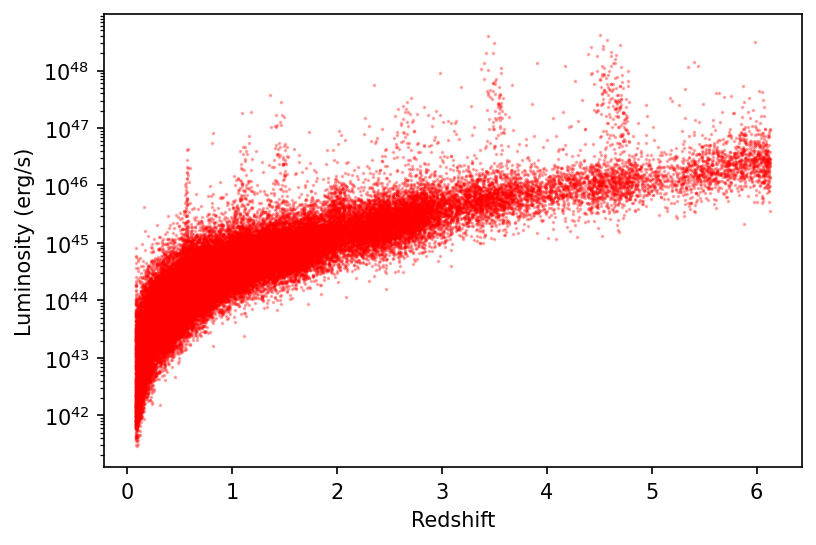

In [62]:
plt.figure(dpi=150)
plt.scatter(matched_quasars['GAIA_redshift'], quasar_luminosities, s=0.5, alpha=0.3, c='r')
plt.yscale('log')
plt.ylabel("Luminosity (erg/s)")
plt.xlabel("Redshift")
plt.show()


Clear spikes in luminosity at certain redshifts, so redshift values from gaia probably not overly reliable or these are not quasars?